In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import cv2
import os
import tensorflow as tf
from pathlib import Path
warnings.filterwarnings('ignore')
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
BASE_PATH = '../input/utkface-new/UTKFace/'
gender_list=[]
age_list=[]
img_paths = []
for filename in os.listdir(BASE_PATH):
    img_path = os.path.join(BASE_PATH,filename)
    temp = filename.split('_')
    age_list.append(int(temp[0]))
    gender_list.append(int(temp[1]))
    img_paths.append(img_path)

# Data preprocessing


In [3]:
df = pd.DataFrame()
df['image'], df['gender'], df['age'] = img_paths, gender_list, age_list
df.head()

,image,gender,age
0,../input/utkface-new/UTKFace/26_0_2_2017010402...,0,26
1,../input/utkface-new/UTKFace/22_1_1_2017011223...,1,22
2,../input/utkface-new/UTKFace/21_1_3_2017010500...,1,21
3,../input/utkface-new/UTKFace/28_0_0_2017011718...,0,28
4,../input/utkface-new/UTKFace/17_1_4_2017010322...,1,17


In [4]:
gender_dict = df['gender'].replace({0:"Male",1:"Female"})

# Exploratory Data Analysis


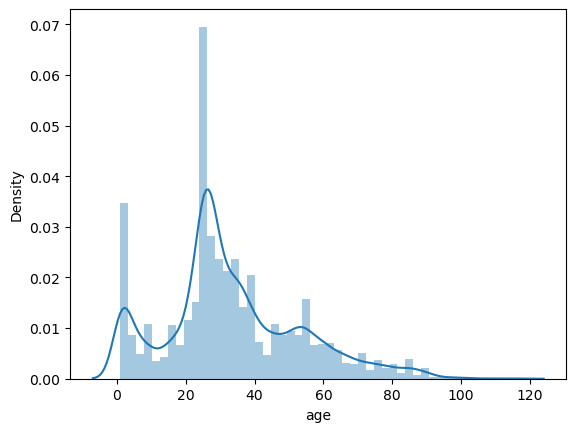

In [5]:
sns.distplot(df['age']);


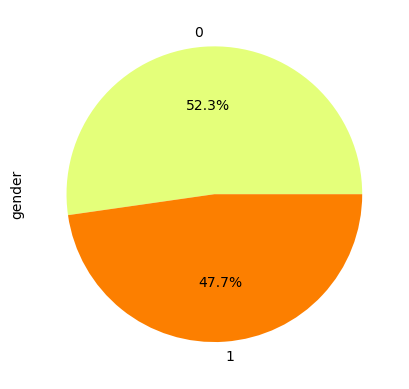

In [6]:
df['gender'].value_counts().plot(kind='pie',autopct="%.1f%%", colormap='Wistia');

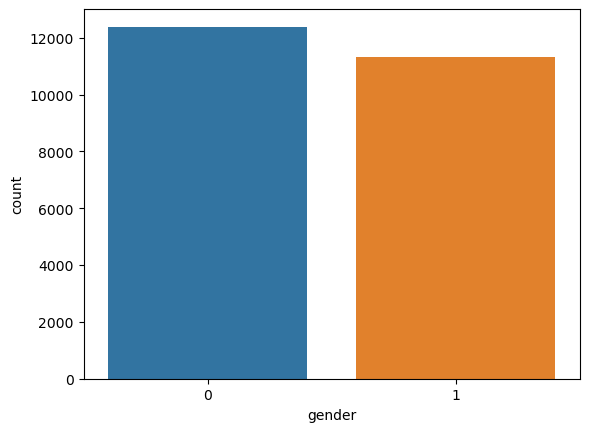

In [7]:
sns.countplot(data=df, x='gender');

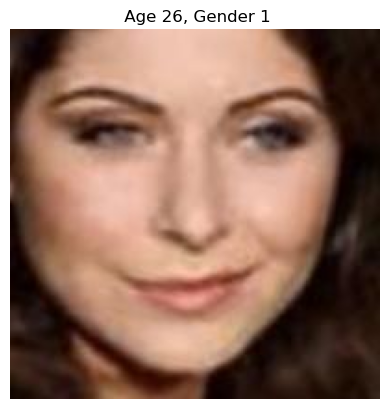

In [8]:
from PIL import Image
img = Image.open(df['image'][15])
plt.title(f' Age {df.age[15]}, Gender {df.gender.loc[15]}')
plt.axis('off')
plt.imshow(img);

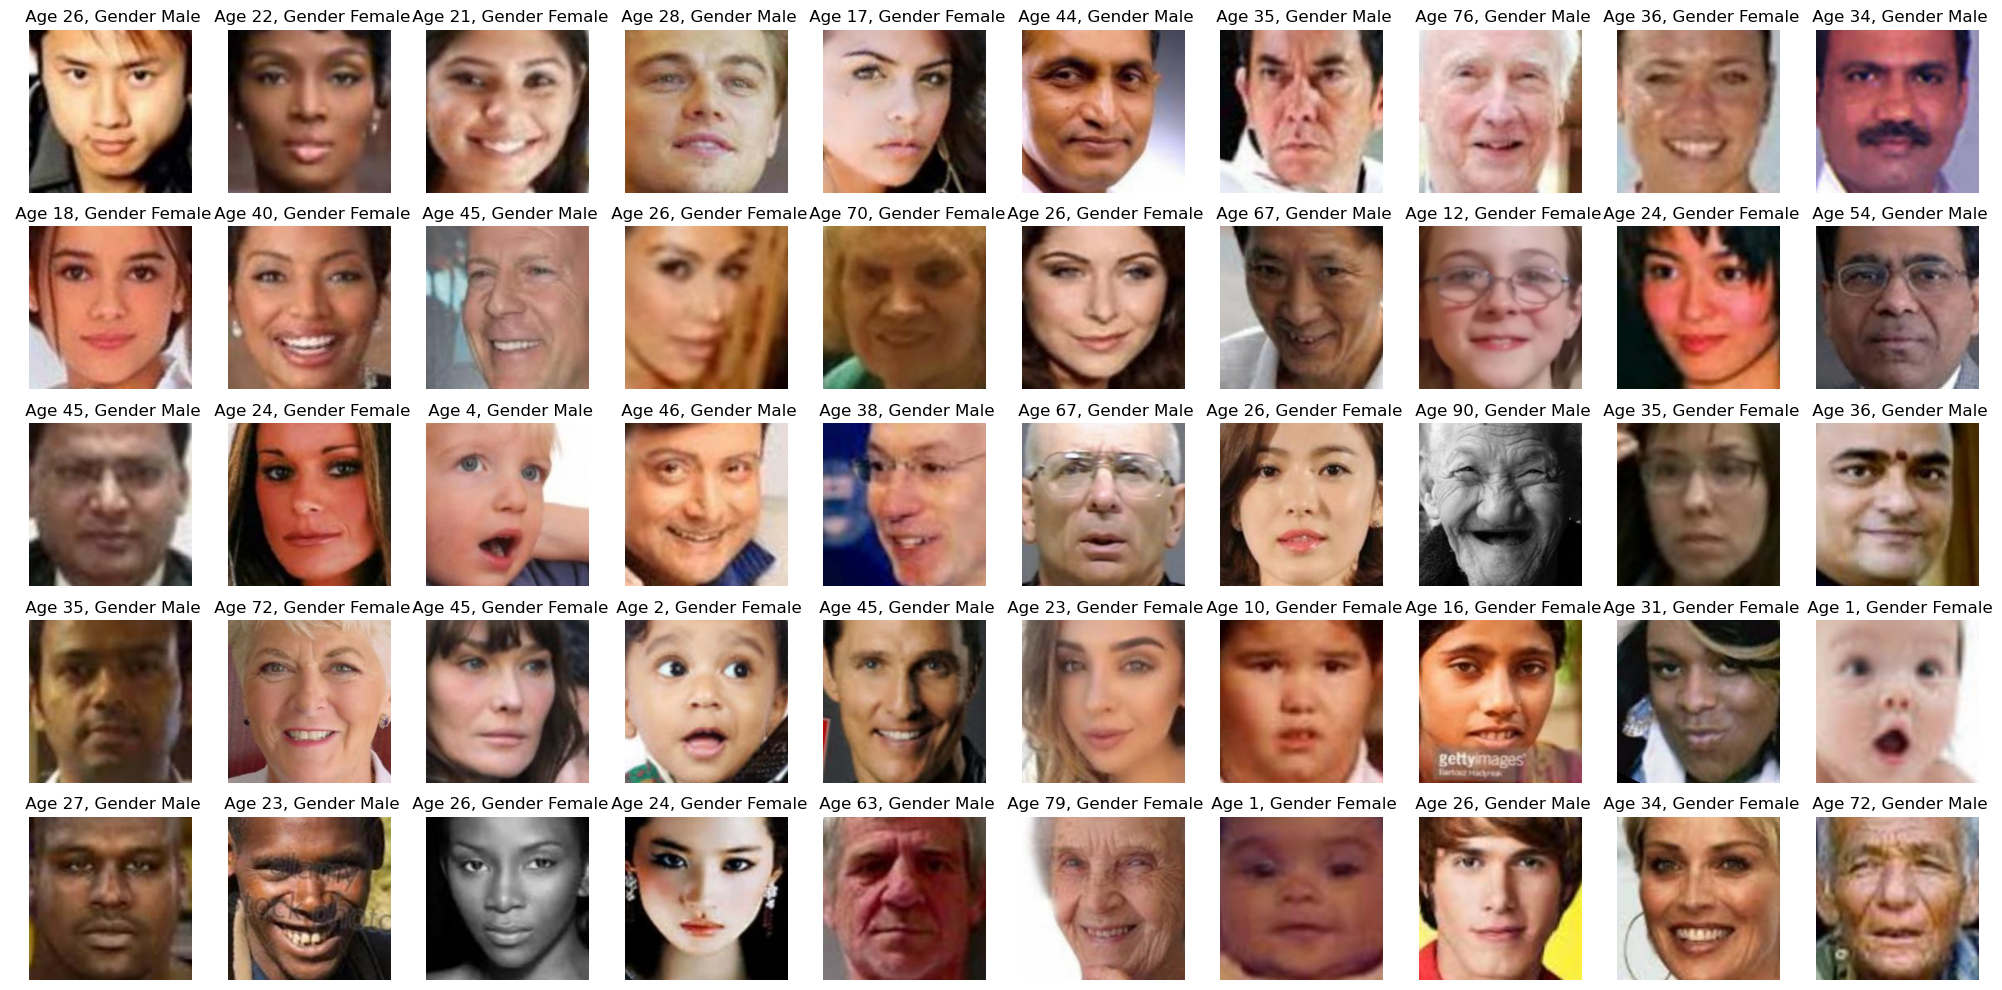

In [9]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(20,10))
for i in range (50):
    plt.subplot(5,10,i+1)
    img = Image.open(df['image'][i])
    plt.title(f' Age {df.age[i]}, Gender {gender_dict.loc[i]}')
    plt.imshow(img);
    plt.axis('off')
plt.tight_layout()

In [10]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Dropout, Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split

In [11]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [12]:
#converting Image to numpy array (extracting feature)
x_train = []
for file in train.image:
    img = load_img(file, grayscale=True)
    img = img.resize((128,128))
    img = np.array(img)
    x_train.append(img)

x_train = np.array(x_train)

x_train = x_train.reshape(len(x_train), 128,128,1)

In [13]:
x_train.shape

(18966, 128, 128, 1)

# Normalizing data

In [14]:
x_train = x_train/255

# train and test

In [15]:
y_gender = np.array(train.gender)
y_age = np.array(train.age)

In [16]:
input_size = (128,128,1)

In [17]:
# Building the CNN model
inputs = Input((input_size))
X = Conv2D(64, (3, 3), activation='relu', kernel_initializer = glorot_uniform(seed=0))(inputs)
X = BatchNormalization(axis = 3)(X)
X = MaxPooling2D((3, 3))(X)

X = Conv2D(128, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)

X = Conv2D(256, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2))(X)

X = Flatten()(X)

dense_1 = Dense(500, activation='relu')(X)
dense_2 = Dense(500, activation='relu' )(X)
dense_3 = Dense(128, activation='relu' )(dense_2)
dropout_1 = Dropout(0.5)(dense_1)
dropout_2 = Dropout(0.5)(dense_3)
output_1 = Dense(1,activation='sigmoid', name='gender_output')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_output')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1,output_2])

In [18]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss',restore_best_weights=True),
]

In [19]:
model.compile(optimizer='adam',loss={'age_output':'mae','gender_output':'binary_crossentropy'},metrics={'age_output':'mae','gender_output':'accuracy'})

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 126, 126, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 126, 126, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [21]:
model_history= model.fit(x=x_train, y=[y_gender, y_age], batch_size = 128, epochs=30, validation_split= 0.2,callbacks=callbacks, shuffle=True)

Epoch 1/30
119/119 [==============================] - 15s 74ms/step - loss: 15.2810 - gender_output_loss: 0.8543 - age_output_loss: 14.4267 - gender_output_accuracy: 0.6734 - age_output_mae: 14.4267 - val_loss: 32.4300 - val_gender_output_loss: 0.6685 - val_age_output_loss: 31.7615 - val_gender_output_accuracy: 0.7704 - val_age_output_mae: 31.7615
Epoch 2/30
119/119 [==============================] - 7s 61ms/step - loss: 11.0969 - gender_output_loss: 0.4525 - age_output_loss: 10.6444 - gender_output_accuracy: 0.7893 - age_output_mae: 10.6444 - val_loss: 30.4458 - val_gender_output_loss: 0.5865 - val_age_output_loss: 29.8594 - val_gender_output_accuracy: 0.8297 - val_age_output_mae: 29.8594
Epoch 3/30
119/119 [==============================] - 7s 62ms/step - loss: 9.8875 - gender_output_loss: 0.4011 - age_output_loss: 9.4863 - gender_output_accuracy: 0.8178 - age_output_mae: 9.4863 - val_loss: 26.2278 - val_gender_output_loss: 0.4952 - val_age_output_loss: 25.7326 - val_gender_output_ac

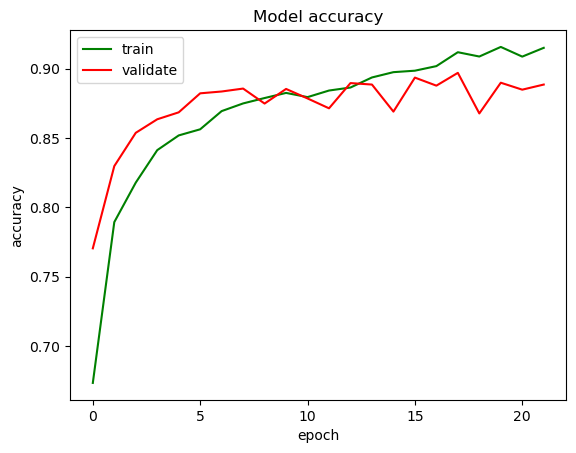

In [22]:
plt.plot(model_history.history['gender_output_accuracy'], 'green')
plt.plot(model_history.history['val_gender_output_accuracy'], 'red')
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left');

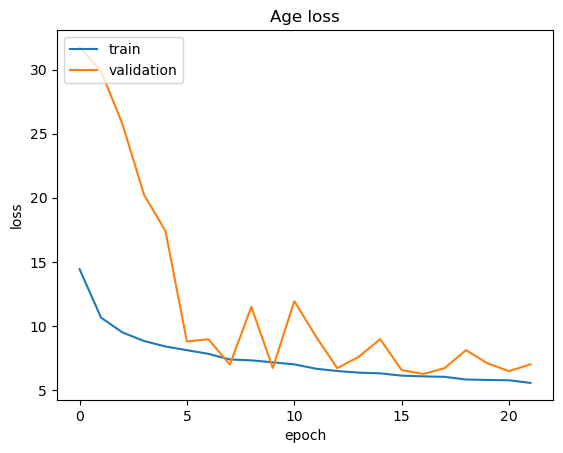

In [23]:
plt.plot(model_history.history['age_output_loss'])
plt.plot(model_history.history['val_age_output_loss'])
plt.title('Age loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

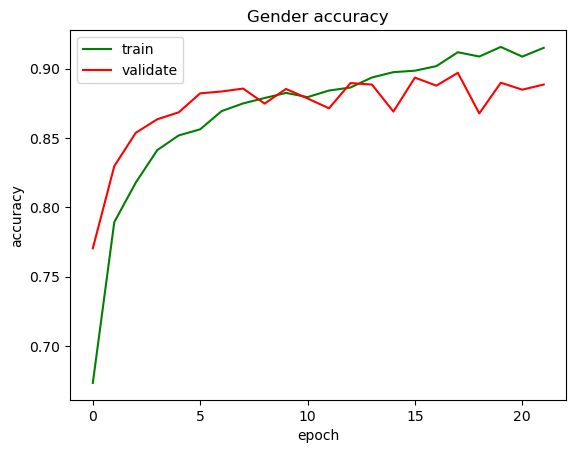

In [24]:
plt.plot(model_history.history['gender_output_accuracy'], 'green')
plt.plot(model_history.history['val_gender_output_accuracy'], 'red')
plt.title('Gender accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left');

1/1 [==============================] - 0s 18ms/step


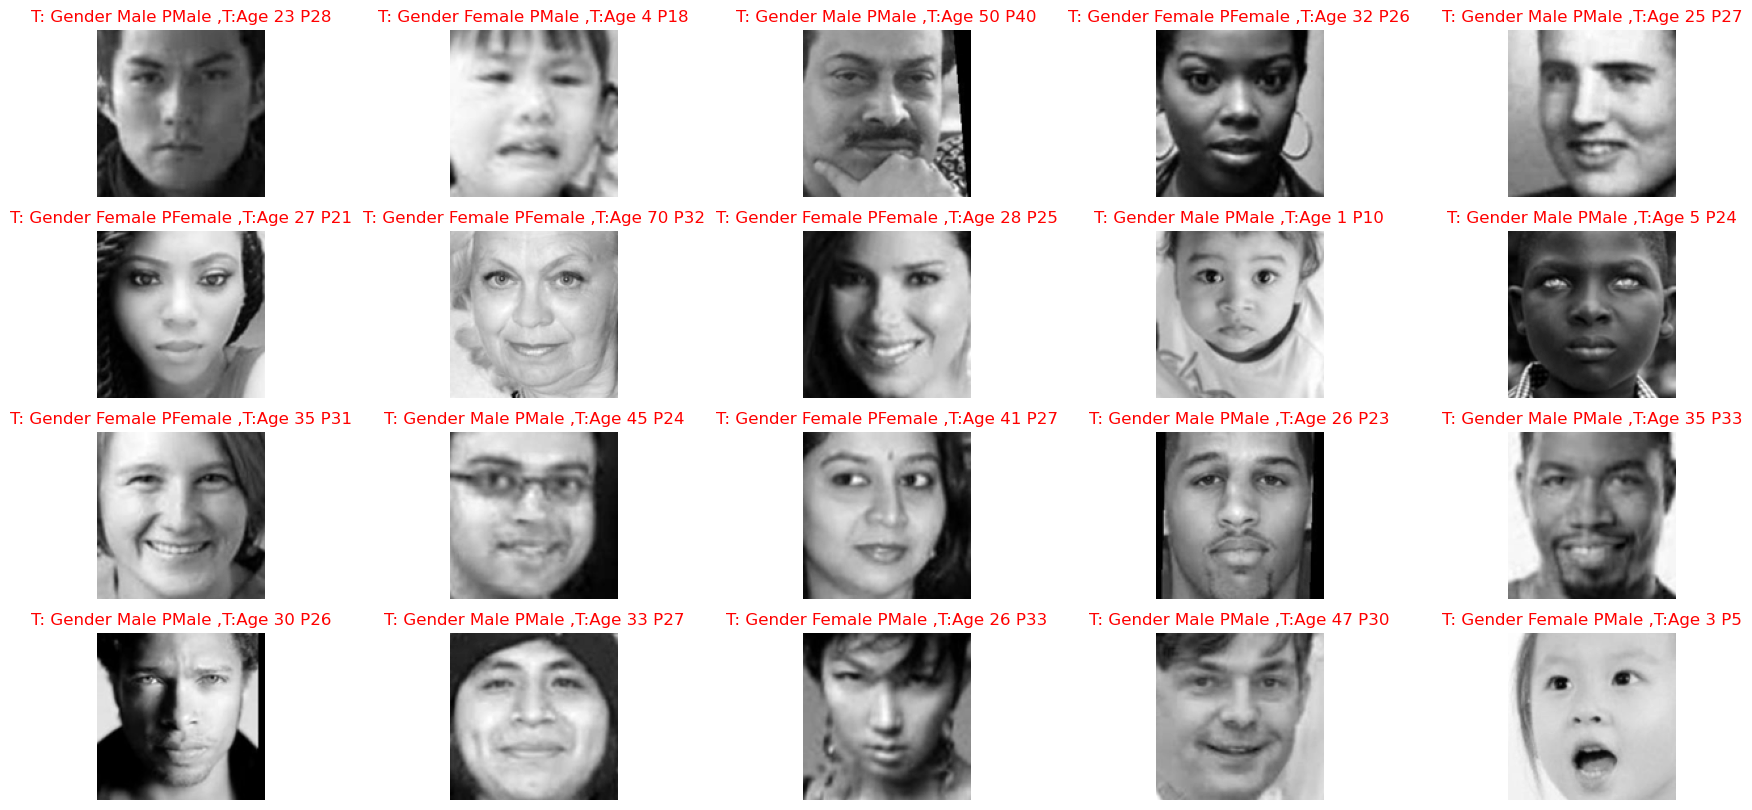

In [167]:
plt.figure(figsize=(22,10))
for index in range (20):
    plt.subplot(4,5,index+1)
    pred = model.predict(x_train[index].reshape(1, 128, 128, 1))
    pred_gender = gender_dict[round(pred[0][0][0])] 
    pred_age = round(pred[1][0][0])
    plt.title("T: Gender {} P{} ,T:Age {} P{}".format(gender_dict[y_gender[index]],pred_gender,y_age[index],pred_age),color='red')
    plt.axis('off')
    plt.imshow(x_train[index],cmap='gray')
    